In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

data = pd.read_csv('data/training_data.csv')

#data['logF/logphi'] = data['ILD_log10'] / np.log10(data['PHIND'])

In [2]:
import seaborn as sns

feature_names = [label for label in list(data.columns) if label not in ('Well Name','Facies','Formation', 'Depth')]

plot_columns = [label for label in list(data.columns) if label not in ('Formation', 'Well Name','Facies', 'Depth', 'NM_M')]


facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [3]:
from sklearn import preprocessing

X = data[feature_names].values
y = data['Facies'].values

imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

well = data['Well Name'].values
depth = data['Depth'].values

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows



X_aug, padded_rows = augment_features(X, well, depth)

In [5]:
X.shape

(3232, 7)

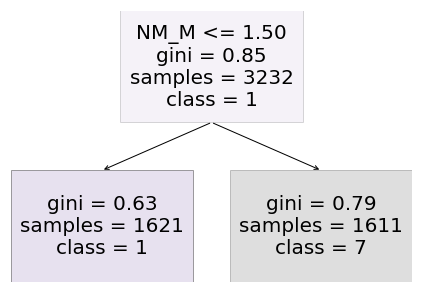

In [6]:
from sklearn import tree
from dtreeplt import dtreeplt

from sklearn import preprocessing


"""le = preprocessing.LabelEncoder()
le.fit(well_log['Formation'])

X['Formation'] = le.transform(well_log['Formation'])"""

model = tree.DecisionTreeClassifier(max_depth=1)
dt_fit = model.fit(X_aug,y)

dtree = dtreeplt(
    filled=True,
    model=model,
    feature_names=4*feature_names,
    target_names=list(range(9)),
    disp_values=False
)

fig = dtree.view()

In [7]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
#well_log[] = well_log.shift(-2)

#well_log.sort_values(['Well Name', 'Depth'], inplace=True)

#well_log.head()

#well_columns_base = well_log.columns

"""lag3, lag10, lag50 = [dc + '_3' for dc in well_log.columns], [dc + '_10' for dc in well_log.columns], [dc + '_50' for dc in well_log.columns]

for col in lag3 + lag10 + lag50:
    well_log[col] = 0

for well in well_log['Well Name'].unique():
    single_well_df = well_log[well_log['Well Name'] == well]
    single_well_df[[dc + '_3' for dc in well_columns_base]] = single_well_df[well_columns_base].shift(3)
    single_well_df[[dc + '_10' for dc in well_columns_base]] = single_well_df[well_columns_base].shift(10)
    single_well_df[[dc + '_50' for dc in well_columns_base]] = single_well_df[well_columns_base].shift(50)


print(well_log.shift(3).shape)
print(well_log.shape)"""""

"lag3, lag10, lag50 = [dc + '_3' for dc in well_log.columns], [dc + '_10' for dc in well_log.columns], [dc + '_50' for dc in well_log.columns]\n\nfor col in lag3 + lag10 + lag50:\n    well_log[col] = 0\n\nfor well in well_log['Well Name'].unique():\n    single_well_df = well_log[well_log['Well Name'] == well]\n    single_well_df[[dc + '_3' for dc in well_columns_base]] = single_well_df[well_columns_base].shift(3)\n    single_well_df[[dc + '_10' for dc in well_columns_base]] = single_well_df[well_columns_base].shift(10)\n    single_well_df[[dc + '_50' for dc in well_columns_base]] = single_well_df[well_columns_base].shift(50)\n\n\nprint(well_log.shift(3).shape)\nprint(well_log.shape)"

In [9]:
#well_log.head()
#well_log[[dc + '_3' for dc in well_columns_base]] = well_log.shift(3)
#well_log[[dc + '_10' for dc in well_columns_base]] = well_log[well_columns_base].shift(10)
#well_log[[dc + '_50' for dc in well_columns_base]] = well_log[well_columns_base].shift(50)

In [10]:
#lag3, lag10, lag50 = [dc + '_3' for dc in well_log.columns], [dc + '_10' for dc in well_log.columns], [dc + '_50' for dc in well_log.columns]

In [11]:
#well_log[(well_log['Well Name'] != well_log['Well Name_3']) | (well_log['Well Name'] != well_log['Well Name_10']) | (well_log['Well Name'] != well_log['Well Name_50'])]
#
#lag_suffix = ['_3', '_10', '_50']
#lag_names = ['Well Name_3', 'Well Name_10', 'Well Name_50']
#
#for lags, names in zip(lag_suffix, lag_names):
#    well_log.loc[well_log['Well Name'] != well_log[names], [dc + lags for dc in well_columns_base]] = well_log[well_columns_base]
#    

In [12]:
#pd.set_option('display.max_columns', None)

#well_log.sample(10)

In [13]:
#well_log.head()

#data_columns = [label for label in list(well_log.columns) if not label.startswith(('Well Name','Facies','Formation', 'Depth'))]
#X = well_log[data_columns]
#Y = well_log['Facies']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.1, random_state=1)

In [15]:
#blind_data = pd.read_csv('data/validation_data_nofacies.csv')
#
#blind_data['logF/logphi'] = blind_data['ILD_log10'] / np.log10(blind_data['PHIND'])
#
#well_columns_base = blind_data.columns
#
#blind_data[[dc + '_3' for dc in well_columns_base]] = blind_data.shift(3)
#blind_data[[dc + '_10' for dc in well_columns_base]] = blind_data[well_columns_base].shift(10)
#blind_data[[dc + '_50' for dc in well_columns_base]] = blind_data[well_columns_base].shift(50)
#blind_data.fillna(method='backfill', inplace=True)
#
#X_blind = blind_data.drop([label for label in list(blind_data.columns) if label.startswith(('Well Name','Facies','Formation', 'Depth'))], axis=1).values
#
#well_blind = blind_data['Well Name'].values
#depth_blind = blind_data['Depth'].values
#
#
#X_blind.shape


blind_data = pd.read_csv('data/validation_data_nofacies.csv')


C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.6516506189821183
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


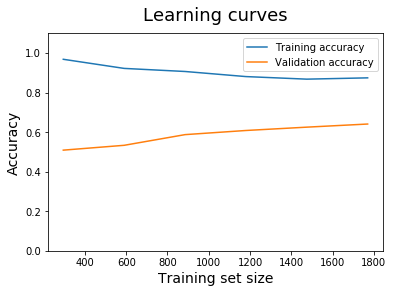

In [16]:
"""
This is the ExtraTreesClassifier

"""
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import learning_curve

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

train_sizes = list(range(295,2065,295))

def tv_scores_mean(estimator, X, y, train_sizes, scoring='accuracy', shuffle=True, cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(estimator = estimator, X=X, y=y, 
                                                                  train_sizes=train_sizes, scoring=scoring, 
                                                                  shuffle=shuffle, cv=cv)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    return train_sizes, train_scores_mean, validation_scores_mean

def plot_learning_curve(train_sizes, train_scores_mean, validation_scores_mean):
    plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1.1)

def randomizedsearch_helper(grid, estimator, X, y):
    gridsearch = model_selection.RandomizedSearchCV(estimator = estimator, param_distributions=grid)
    gridsearch.fit(X,y)
    return (gridsearch.best_estimator_, gridsearch.best_score_, gridsearch.best_params_)

def model_helper(grid, classifier, X, y, randomsearch = True):
    if randomsearch:
        est, acc, param = randomizedsearch_helper(grid, classifier, X, y)
    else:
        est, acc, param = gridsearch_helper(grid, classifier, X, y)
    est.fit(X_train,y_train)
    print(acc)
    print(est)
    return (est, acc, param)

cart_grid = {'max_depth' : range(3,10)}
result = model_helper(cart_grid, DecisionTreeClassifier(random_state=1), X_train, y_train)
cart_est = result[0]

plot_learning_curve(*tv_scores_mean(cart_est,X_train,y_train,train_sizes))

In [18]:
from sklearn.ensemble import GradientBoostingClassifier


rfc_grid = {'n_estimators' : range(100,300,50), 'min_samples_leaf': [6], 
            'min_samples_split':range(2,10,2), 'learning_rate':[0.03, 0.04, 0.05], 
            'subsample':[0.4, 0.6], 'max_depth':range(2,4,1)}


#Try n_estimators higher after this one 

def train_gbc(X_train, y_train, rfc_grid):
    result = model_helper(rfc_grid, GradientBoostingClassifier(random_state=1), X_train, y_train)
    gbc_est = result[0]
    plot_learning_curve(*tv_scores_mean(gbc_est,X_train,y_train,train_sizes))
    return gbc_est


#gbc_est = train_gbc(X_train, y_train, rfc_grid)

In [19]:
test_data = pd.read_csv('data/validation_data_nofacies.csv')

#test_data['logF/logphi'] = test_data['ILD_log10'] / np.log10(test_data['PHIND'])

well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values

X_test.shape


(324, 28)

In [20]:
X_test, _ = augment_features(X_ts, well_ts, depth_ts)

X_test.shape

(830, 28)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import GradientBoostingClassifier

print('.' * 20)
y_pred = []
for seed in range(20):
    np.random.seed(seed)

    clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=3,
              max_features=0.9, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=6, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto',
              subsample=0.4, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

    clf.fit(X_train, y_train)
    X_test, _ = augment_features(X_ts, well_ts, depth_ts)
    y_blind = clf.predict(X_test)
    #y_blind = medfilt(y_blind, kernel_size=5)
    y_pred.append(y_blind)
    print('|', end='')

np.save('NS-Team_100_realizations.npy', y_pred)

....................
||||||||

In [ ]:
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier


def train_and_test(X_tr, y_tr, X_v, well_v, clf):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

In [ ]:
#Load testing data

from sklearn.pipeline import make_pipeline, make_union
from scipy.signal import medfilt

test_data = pd.read_csv('data/validation_data_nofacies.csv')

#test_data['logF/logphi'] = test_data['ILD_log10'] / np.log10(test_data['PHIND'])

    # Train classifier
    #clf = make_pipeline(make_union(VotingClassifier([("est", ExtraTreesClassifier(criterion="gini", max_features=1.0, n_estimators=500))]), FunctionTransformer(lambda X: X)), XGBClassifier(learning_rate=0.73, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.27))
    #clf =  make_pipeline( KNeighborsClassifier(n_neighbors=5, weights="distance") ) 
    #clf = make_pipeline(MaxAbsScaler(),make_union(VotingClassifier([("est", RandomForestClassifier(n_estimators=500))]), FunctionTransformer(lambda X: X)),ExtraTreesClassifier(criterion="entropy", max_features=0.0001, n_estimators=500))
    # * clf = make_pipeline( make_union(VotingClassifier([("est", BernoulliNB(alpha=60.0, binarize=0.26, fit_prior=True))]), FunctionTransformer(lambda X: X)),RandomForestClassifier(n_estimators=500))

# # Prepare training data
# X_tr = X
# y_tr = y

# # Augment features
# X_tr, padded_rows = augment_features(X_tr, well, depth)

# # Removed padded rows
# X_tr = np.delete(X_tr, padded_rows, axis=0)
# y_tr = np.delete(y_tr, padded_rows, axis=0) 

# Prepare test data
well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values


    
y_pred = []
print('.' * 10)
for seed in range(10):
    np.random.seed(seed)

    # Make training data.
    X_train, padded_rows = augment_features(X, well, depth)
    y_train = y
    X_train = np.delete(X_train, padded_rows, axis=0)
    y_train = np.delete(y_train, padded_rows, axis=0) 

    # Train classifier  
    clf = make_pipeline(XGBClassifier(learning_rate=0.12,
                                      max_depth=3,
                                      min_child_weight=10,
                                      n_estimators=150,
                                      seed=seed,
                                      colsample_bytree=0.9))

    # Make blind data.
    X_test, _ = augment_features(X_ts, well_ts, depth_ts)

    # Train and test.
    y_ts_hat = train_and_test(X_train, y_train, X_test, well_ts, clf)
    
    # Collect result.
    y_pred.append(y_ts_hat)
    print('|', end='')
    
np.save('LA_Team_100_realizations.npy', y_pred)

In [ ]:
hist,bins = np.histogram(y_pred)
plt.hist(y_pred, bins)

In [ ]:
from sklearn.metrics import confusion_matrix

PRED = pd.read_csv('data/prediction_depths.csv')
PRED.set_index(["Well Name", "Depth"], inplace=True)
PRED.head()

TRUE = pd.read_csv('data/blind_stuart_crawford_core_facies.csv')
TRUE.rename(columns={'Depth.ft': 'Depth'}, inplace=True)
TRUE.rename(columns={'WellName': 'Well Name'}, inplace=True)
TRUE.set_index(["Well Name", "Depth"], inplace=True)
TRUE.head()


def get_accuracies(y_preds):
    """
    Get the F1 scores from all the y_preds.
    y_blind is a 1D array. y_preds is a 2D array.
    """
    accs = []
    for y_pred in y_preds:
        PRED['Facies'] = y_pred
        all_data = PRED.join(TRUE, how='inner')
        y_blind = all_data['LithCode'].values
        y_pred = all_data['Facies'].values
        y_pred = y_pred[y_blind!=11]
        y_blind = y_blind[y_blind!=11]
        cv_conf = confusion_matrix(y_blind, y_pred)
        #sns.heatmap(cv_conf, annot=True, fmt="d")
        accs.append(accuracy(cv_conf))
    return np.array(accs)

In [ ]:
from os import path
from utils import accuracy
import operator

scores, medians = {}, {}
for f in ['LA_Team_100_realizations.npy']:
    team = path.basename(f).split('_')[0]
    y_preds = np.load(f)
    scores[team] = get_accuracies(y_preds)
    medians[team] = np.median(scores[team])
    plt.hist(pd.Series(scores[team]), alpha=0.5)

for t, m in sorted(medians.items(), key=operator.itemgetter(1), reverse=True):
    print("{:20s}{:.4f}".format(t, m))

In [ ]:
y_pred = y_preds[0]
PRED['Facies'] = y_pred
all_data = PRED.join(TRUE, how='inner')
y_blind = all_data['LithCode'].values
y_pred = all_data['Facies'].values
y_pred = y_pred[y_blind!=11]
y_blind = y_blind[y_blind!=11]
cv_conf = confusion_matrix(y_blind, y_pred)
sns.heatmap(cv_conf, annot=True, fmt="d")